In [ ]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2

### **Setup Environment**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
!git clone https://github.com/CamiloMartinezM/ultralytics.git
%cd /content/ultralytics
!pip install -e .
!pip install roboflow
!pip install -U transformers
!pip install datasets
!pip install wandb
!pip install accelerate -U
!pip install python-dotenv
%cd /content

In [ ]:
from importlib.util import find_spec
import os
import shutil

if find_spec("google"):
    from google.colab import userdata
    if userdata.get("REPO_API_KEY"):
        os.environ["REPO_API_KEY"] = userdata.get("REPO_API_KEY")

URL = f"https://{os.getenv('REPO_API_KEY')}@github.com/dhimitriosduka1/hlcv.git"
!git clone {URL}

source_dir = "/content/hlcv/Project/src/fretboard-recognition/"
destination_dir = "/content/"

# Iterate through all items in the source directory
for item in os.listdir(source_dir):
    source_item = os.path.join(source_dir, item)
    destination_item = os.path.join(destination_dir, item)
    if os.path.exists(destination_item):
        !rm -rf {destination_item}
    shutil.move(source_item, destination_item)

!rm -rf /content/hlcv
!python /content/validate/download_coco.py

In [ ]:
from make_custom_coco import main as make_custom_coco

make_custom_coco()

### **Training an R-CNN (with `detectron2`)**

In [ ]:
import os
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances

setup_logger()

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")

CUSTOM_DATASET_NAME = "guitar-necks-detector"
DATASET_DIR = os.path.join(DATASETS_DIR, CUSTOM_DATASET_NAME)

# Set up the dataset in data/{CUSTOM_DATASET_NAME}
for set_ in ["train", "valid", "test"]:
    register_coco_instances(
        f"{CUSTOM_DATASET_NAME}_{set_}",
        {},
        os.path.join(DATASETS_DIR, CUSTOM_DATASET_NAME, set_, "labels", "_annotations.coco.json"),
        os.path.join(DATASETS_DIR, CUSTOM_DATASET_NAME, set_, "images"),
    )

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = f"{CUSTOM_DATASET_NAME}_train"
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 32
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
import os
import shutil
from datetime import datetime
from gc import collect as garbage_collect
from warnings import warn

import torch
import yaml
from datasets import load_dataset
from dotenv import load_dotenv
from roboflow import Roboflow
from torch.cuda import empty_cache as cuda_empty_cache
from torch.cuda import mem_get_info

load_dotenv()  # load environment variables stored in .env file (e.g., API keys)

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")

# Useful functions


def clean_cache():
    """Cleans the GPU memory cache."""
    garbage_collect()
    cuda_empty_cache()
    mem_info = mem_get_info()
    print(
        f"Freeing GPU Memory\nFree: %d MB\tTotal: %d MB"
        % (mem_info[0] // 1024**2, mem_info[1] // 1024**2)
    )


def safe_save(model: torch.nn.Module, final_model_path: str) -> None:
    """Saves a model to a file, ensuring that the file does not already exist. If it does, it
    renames the existing file."""
    # Ensure the directory exists
    os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

    if os.path.exists(final_model_path):
        # Get current timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H_%M_%S")

        # Split the path into directory, filename, and extension
        directory, filename = os.path.split(final_model_path)
        name, ext = os.path.splitext(filename)

        # Create new filename with timestamp
        new_filename = f"{name}_{timestamp}{ext}"
        new_path = os.path.join(directory, new_filename)

        warn(f"{final_model_path} already exists. Renaming existing file to: {new_filename}")

        # Rename the existing file
        shutil.move(final_model_path, new_path)

    # Save the new model
    model.save(final_model_path)
    print(f"New model saved as: {final_model_path}")


def load_config(config_path: str) -> dict:
    """Loads a YAML config file."""
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


def to_path(*args):
    """Converts a list of strings into a path, from the current directory saved in `CURRENT_DIR`."""
    # If "/" is present in one of the strings, it is separated into a list of strings, such that we
    # use the safe `os.path.join` function.
    path_parts = []
    for arg in args:
        if "/" in arg:
            path_parts.extend(arg.split("/"))
        else:
            path_parts.append(arg)

    return os.path.join(CURRENT_DIR, *path_parts)


def download_from(config: dict) -> None:
    """Downloads a dataset using the loaded `config`. It must have the following structure:

    ```
    data:
        dataset: e.g., "guitar-necks-detector" or "dduka/guitar-chords" # The name of the dataset
        load:
            interface: "roboflow" or "datasets"
            # (These must be available only if interface is "roboflow":)
            workspace: "..."
            project-version: "1"
            version-download: "..."
    ```
    """
    if config["data"]["load"]["interface"] == "roboflow":
        # Test if a ROBOFLOW_API_KEY is available
        if not os.getenv("ROBOFLOW_API_KEY"):
            from importlib.util import find_spec

            if find_spec("google"):
                from google.colab import userdata

                if userdata.get("ROBOFLOW_API_KEY"):
                    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
            else:
                raise ValueError(
                    "ROBOFLOW_API_KEY is not available in the environment variables. "
                    + "Create a .env file in this directory with the key or in Google "
                    + "Colab, add it to secret keys."
                )

        # Initialize Roboflow
        rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))

        # Access the workspace and project
        project = rf.workspace(config["data"]["load"]["workspace"]).project(
            config["data"]["dataset"]
        )
        version = project.version(config["data"]["load"]["project-version"])
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = version.download(config["data"]["load"]["version-download"], location=dataset_path)
    elif config["data"]["load"]["interface"] == "datasets":
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = load_dataset("dduka/guitar-chords", cache_dir=dataset_path)

    return ds, dataset_path

In [ ]:
FINAL_MODELS_DIR = to_path("final_models")
ORIGINAL_MODELS_DIR = to_path("original_models")
IMAGES_DIR = to_path("images")

In [ ]:
f_run_config = "config-yolo-v9.yml"
f_wandb_config = "wandb.yml"

In [ ]:
# Load configuration
config = load_config(to_path(f_run_config))
wandb_config = load_config(to_path(f_wandb_config))

### **Training an R-CNN (with `fasterrcnn_resnet50_fpn`)**

In [ ]:
from make_custom_coco import main as make_custom_coco

# This will download the guitar-necks-detector dataset from Roboflow and create a custom COCO
# dataset from it in data/
make_custom_coco()

In [1]:
import os

import numpy as np
import torch
import wandb
from general_config import Config
from torchvision.io import read_image
from transformers import EarlyStoppingCallback, TrainingArguments

from common.callbacks import CustomWandbCallback
from common.collate_util import collate_fn
from common.configs import ObjectDetectorConfig
from common.custom_datasets import GuitarNeckDataset
from common.metrics import compute_metrics, log_table_data
from common.models import ObjectDetector
from common.trainers import CustomTrainer
from common.utils import (
    available_device,
    clean_cache,
    ensure_directory_exists,
    get_coco_names,
    get_custom_coco,
    load_config,
    predict,
    safe_save,
    show,
)
from common.visualization import draw_colored_boxes

# Constants
CUSTOM_DATASET_NAME = "guitar-necks-detector"
DATASET_DIR = os.path.join(Config.DATA_DIR, CUSTOM_DATASET_NAME)
COCO_NAMES = get_coco_names()
CUSTOM_COCO_NAMES, FRETBOARD_CLASS_LABEL = get_custom_coco("fretboard")

print(f"Fretboard class label: {FRETBOARD_CLASS_LABEL}")

# Ensure the directory exist
ensure_directory_exists(DATASET_DIR, make=False)

/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fretboard class label: 12
The directory /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/data/guitar-necks-detector exists.


In [2]:
clean_cache()

# Load the model and wandb configuration
config = load_config(os.path.join(Config.CONFIGS_DIR, "config-cnn-object-detector.yml"))
wandb_config = load_config(os.path.join(Config.CONFIGS_DIR, "wandb.yml"))

# Load the FasterRCNN model with the configuration
model_config = ObjectDetectorConfig(**config["model"])
model = ObjectDetector(model_config)
model = model.to(available_device(verbose=True))

Freeing GPU Memory
Free: 7701 MB	Total: 7843 MB
Using GPU for training


In [3]:
# Create datasets for each split
train_dataset, eval_dataset, test_dataset = GuitarNeckDataset.from_dir(
    root_dir=DATASET_DIR,
    transforms=model.get_transforms(),
    class_label=FRETBOARD_CLASS_LABEL,
)

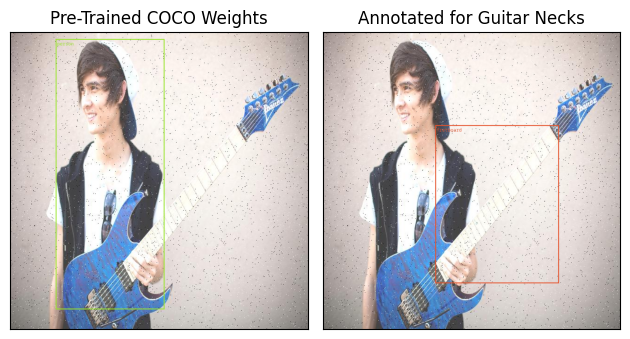

In [4]:
# Inference test before fine-tuning
model.eval()

image, target = train_dataset[45]

boxes, classes, labels = predict(image, model, available_device(), 0.6, 0.2, names=COCO_NAMES)

# Draw bounding boxes.
drawn_boxes = draw_colored_boxes(
    image, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES, show=False
)
drawn_boxes2 = draw_colored_boxes(
    image,
    target["boxes"],
    classes=target["labels"].tolist(),
    class_names=CUSTOM_COCO_NAMES,
    show=False,
)
show([drawn_boxes, drawn_boxes2], titles=["Pre-Trained COCO Weights", "Annotated for Guitar Necks"])

In [5]:
clean_cache()

model.train()

# Initialize wandb
run_name = config["model"]["name"] + "-" + wandb.util.generate_id()
wandb.init(
    project=wandb_config["project"],
    name=run_name,
    entity=wandb_config["entity"],
    config=config,
)

# Define training arguments
training_args = TrainingArguments(
    output_dir=config["training"]["output_dir"],
    num_train_epochs=config["training"]["num_epochs"],
    per_device_train_batch_size=config["training"]["batch_size"],
    per_device_eval_batch_size=config["training"]["batch_size"],
    logging_dir=config["training"]["logging_dir"],
    logging_steps=config["training"]["logging_steps"],
    warmup_steps=config["training"]["warmup_steps"] if "warmup_steps" in config["training"] else 0,
    weight_decay=config["training"]["weight_decay"] if "weight_decay" in config["training"] else 0,
    eval_strategy=config["training"]["eval_strategy"],
    save_strategy=config["training"]["eval_strategy"],
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="mAP50",
    learning_rate=float(config["training"]["learning_rate"]),
    greater_is_better=True,
    logging_strategy=config["training"]["eval_strategy"],
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=config["training"].get("early_stopping_patience", 3)
)

my_wandb_callback = CustomWandbCallback()

# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[early_stopping_callback, my_wandb_callback],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

# Start training
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Freeing GPU Memory
Free: 7529 MB	Total: 7843 MB


wandb: Currently logged in as: cama00005 (hwga-cj). Use `wandb login --relogin` to force relogin


  5%|▌         | 116/2320 [01:39<23:47,  1.54it/s]

{'loss': 1.7514, 'grad_norm': 8.336114883422852, 'learning_rate': 2.32e-05, 'epoch': 1.0, 'train_loss': 203.16468811035156, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
                                                  
  5%|▌         | 116/2320 [01:47<23:47,  1.54it/s]

{'eval_loss': 13.217826843261719, 'eval_mAP50': 0.9200834631919861, 'eval_mAP50-95': 0.7461670637130737, 'eval_precision': 0.3766975905376632, 'eval_recall': 0.3901810659789383, 'eval_runtime': 7.7797, 'eval_samples_per_second': 11.311, 'eval_steps_per_second': 1.414, 'epoch': 1.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


 10%|█         | 232/2320 [03:26<21:53,  1.59it/s]  

{'loss': 0.9427, 'grad_norm': 8.172069549560547, 'learning_rate': 4.64e-05, 'epoch': 2.0, 'train_loss': 109.35395050048828, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 10%|█         | 232/2320 [03:34<21:53,  1.59it/s]

{'eval_loss': 9.169116020202637, 'eval_mAP50': 0.9368184804916382, 'eval_mAP50-95': 0.7856950759887695, 'eval_precision': 0.38930614696707344, 'eval_recall': 0.414929436206032, 'eval_runtime': 7.61, 'eval_samples_per_second': 11.564, 'eval_steps_per_second': 1.445, 'epoch': 2.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


 15%|█▌        | 348/2320 [05:14<20:42,  1.59it/s]  

{'loss': 0.7798, 'grad_norm': 9.093292236328125, 'learning_rate': 6.96e-05, 'epoch': 3.0, 'train_loss': 90.46100616455078, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 15%|█▌        | 348/2320 [05:21<20:42,  1.59it/s]

{'eval_loss': 9.204553604125977, 'eval_mAP50': 0.932020366191864, 'eval_mAP50-95': 0.7544185519218445, 'eval_precision': 0.3764368751910029, 'eval_recall': 0.39801830360340995, 'eval_runtime': 7.5574, 'eval_samples_per_second': 11.644, 'eval_steps_per_second': 1.456, 'epoch': 3.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


 20%|██        | 464/2320 [07:01<19:30,  1.58it/s]  

{'loss': 0.7361, 'grad_norm': 9.446199417114258, 'learning_rate': 9.28e-05, 'epoch': 4.0, 'train_loss': 85.39279174804688, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 20%|██        | 464/2320 [07:09<19:30,  1.58it/s]

{'eval_loss': 8.960497856140137, 'eval_mAP50': 0.9482326507568359, 'eval_mAP50-95': 0.783950686454773, 'eval_precision': 0.3854051671759091, 'eval_recall': 0.39965792678558637, 'eval_runtime': 7.5781, 'eval_samples_per_second': 11.612, 'eval_steps_per_second': 1.452, 'epoch': 4.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


 25%|██▌       | 580/2320 [08:48<18:13,  1.59it/s]  

{'loss': 0.7173, 'grad_norm': 22.694869995117188, 'learning_rate': 9.560439560439561e-05, 'epoch': 5.0, 'train_loss': 83.2048110961914, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 25%|██▌       | 580/2320 [08:56<18:13,  1.59it/s]

{'eval_loss': 9.01384449005127, 'eval_mAP50': 0.9437885284423828, 'eval_mAP50-95': 0.7616997957229614, 'eval_precision': 0.37973802318486943, 'eval_recall': 0.3972849057955441, 'eval_runtime': 7.5398, 'eval_samples_per_second': 11.671, 'eval_steps_per_second': 1.459, 'epoch': 5.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


 30%|███       | 696/2320 [10:35<17:00,  1.59it/s]  

{'loss': 0.695, 'grad_norm': 2.0153403282165527, 'learning_rate': 8.923076923076924e-05, 'epoch': 6.0, 'train_loss': 80.62364196777344, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


                                                  
 30%|███       | 696/2320 [10:43<17:00,  1.59it/s]

{'eval_loss': 8.794400215148926, 'eval_mAP50': 0.9542517066001892, 'eval_mAP50-95': 0.8178709149360657, 'eval_precision': 0.41554089532413496, 'eval_recall': 0.4259304033240203, 'eval_runtime': 7.5417, 'eval_samples_per_second': 11.668, 'eval_steps_per_second': 1.459, 'epoch': 6.0, 'train_cls_loss': 0.0, 'train_box_loss': 0.0, 'eval_cls_loss': 0.0, 'eval_box_loss': 0.0}


 33%|███▎      | 775/2320 [11:51<22:12,  1.16it/s]  

In [ ]:
# Clean the GPU memory cache
clean_cache()

# Log table data at the end of training
log_table_data(trainer, per_device_eval_batch_size=8)

# Save the final model
safe_save(trainer, os.path.join(Config.FINAL_MODELS_DIR, config["model"]["name"]))

# Evaluate on test set if available
if test_dataset:
    test_results = trainer.evaluate(test_dataset)
    print(f"Test results: {test_results}")
    wandb.log({"test": test_results})

# Log performance metrics
wandb.log(trainer.model_performance_analysis())

# Finish wandb run
wandb.finish()

In [ ]:
model.eval()

image, target = train_dataset[45]

boxes, classes, labels = predict(
    image, model, available_device(), 0.2, 0.2, names=CUSTOM_COCO_NAMES
)

# Draw bounding boxes.
drawn_boxes = draw_colored_boxes(
    image, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES, show=False
)
drawn_boxes2 = draw_colored_boxes(
    image,
    target["boxes"],
    classes=target["labels"].tolist(),
    class_names=CUSTOM_COCO_NAMES,
    show=False,
)
show([drawn_boxes, drawn_boxes2], titles=["Fast R-CNN Prediction", "Fretboard Annotation"])
print(f"Predicted classes: {np.unique(classes)}")

In [ ]:
model.eval()

img_path = os.path.join(Config.IMAGES_DIR, "FudanPed00054.png")
orig_img = read_image(img_path)

boxes, classes, labels = predict(
    orig_img,
    model,
    available_device(),
    0.1,
    0.1,
    model_transforms=model.get_transforms(),
    names=CUSTOM_COCO_NAMES,
)

drawn_boxes = draw_colored_boxes(orig_img, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES)
print(f"Predicted classes: {np.unique(classes)}")

In [ ]:
model.eval()

image, target = train_dataset[45]

boxes, classes, labels = predict(
    image, model, available_device(), 0.2, 0.2, names=CUSTOM_COCO_NAMES
)

# Draw bounding boxes.
drawn_boxes = draw_colored_boxes(image, boxes, classes=classes, class_names=CUSTOM_COCO_NAMES)
print(f"Predicted classes: {np.unique(classes)}")

In [ ]:
from common.utils import rename_folder

rename_folder(
    os.path.join(Config.FINAL_MODELS_DIR, config["model"]["name"]),
    os.path.join(
        Config.FINAL_MODELS_DIR,
        config["model"]["name"]
        + "_"
        + f"{'finetuned' if config['model']['trainable_backbone_layers'] == 5 else 'frozen_backbone'}",
    ),
)